<a href="https://colab.research.google.com/github/buketugurlu/BUSI/blob/main/BUSI_resnet_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Load all image and mask paths
image_paths = []
mask_paths = []
for cls in ['benign', 'malignant']:
    image_dir = os.path.join(base_dir, cls)
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "_mask" not in filename:
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
            image_paths.append(image_path)
            mask_paths.append(mask_path)

# Split dataset into train, validation, and test
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)  # 70% train, 30% temp (validation + test)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)  # Split 30% into 15% validation, 15% test

print(f"Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}")

# Image and mask transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = BreastUltrasoundDataset(train_images, train_masks, transform_image, transform_mask)
val_dataset = BreastUltrasoundDataset(val_images, val_masks, transform_image, transform_mask)
test_dataset = BreastUltrasoundDataset(test_images, test_masks, transform_image, transform_mask)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# ResNet50-based segmentation model
class ResNetSegmentationModel(nn.Module):
    def __init__(self, weights=ResNet50_Weights.IMAGENET1K_V1, num_classes=1):
        super(ResNetSegmentationModel, self).__init__()
        # Load pretrained ResNet50
        self.encoder = resnet50(weights=weights)
        self.encoder.fc = nn.Identity()  # Remove classification head
        self.encoder.avgpool = nn.Identity()  # Remove avgpool to preserve spatial dimensions

        # Decoder head
        self.decoder = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),  # Upsample to match input size
            nn.Conv2d(64, num_classes, kernel_size=1),  # Final output
        )

    def forward(self, x):
        x = F.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)  # Resize for ResNet50
        features = self.encoder(x)  # Get encoder features (preserve spatial dimensions)

        if len(features.shape) == 2:  # Flattened tensor [batch_size, 2048]
            batch_size = features.size(0)
            features = features.view(batch_size, 2048, 8, 8)  # Reshape to spatial dimensions

        return self.decoder(features)  # Decode features for segmentation

# Model initialization
model = ResNetSegmentationModel(weights=ResNet50_Weights.IMAGENET1K_V1, num_classes=1).to(device)

# Loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop with Validation
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            predictions = model(images)
            loss = loss_function(predictions, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/resnet_segmentation_model.pth')

# Test the model
def evaluate_model(dataset, model):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for image, mask in dataset:
            image = image.unsqueeze(0).to(device)
            mask = mask.squeeze().cpu().numpy()
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)
            all_preds.append(prediction_binary.flatten())
            all_masks.append(mask.flatten())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    dice_score = (2.0 * np.logical_and(y_true, y_pred).sum()) / (y_true.sum() + y_pred.sum() + 1e-6)
    iou = np.logical_and(y_true, y_pred).sum() / (np.logical_or(y_true, y_pred).sum() + 1e-6)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Dice: {dice_score:.4f}, IoU: {iou:.4f}")

evaluate_model(test_dataset, model)


Using device: cuda
Mounted at /content/drive
Train size: 452, Validation size: 97, Test size: 98


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


Epoch 1/20, Train Loss: 0.3110, Val Loss: 0.1855
Epoch 2/20, Train Loss: 0.1712, Val Loss: 0.1655
Epoch 3/20, Train Loss: 0.1347, Val Loss: 0.1454
Epoch 4/20, Train Loss: 0.1178, Val Loss: 0.1574
Epoch 5/20, Train Loss: 0.0887, Val Loss: 0.1338
Epoch 6/20, Train Loss: 0.0881, Val Loss: 0.1116
Epoch 7/20, Train Loss: 0.0869, Val Loss: 0.1206
Epoch 8/20, Train Loss: 0.0671, Val Loss: 0.1224
Epoch 9/20, Train Loss: 0.0612, Val Loss: 0.1255
Epoch 10/20, Train Loss: 0.0563, Val Loss: 0.1308
Epoch 11/20, Train Loss: 0.0484, Val Loss: 0.1265
Epoch 12/20, Train Loss: 0.0436, Val Loss: 0.1467
Epoch 13/20, Train Loss: 0.0381, Val Loss: 0.1381
Epoch 14/20, Train Loss: 0.0378, Val Loss: 0.1416
Epoch 15/20, Train Loss: 0.0353, Val Loss: 0.1396
Epoch 16/20, Train Loss: 0.0322, Val Loss: 0.1557
Epoch 17/20, Train Loss: 0.0290, Val Loss: 0.1429
Epoch 18/20, Train Loss: 0.0282, Val Loss: 0.1681
Epoch 19/20, Train Loss: 0.0276, Val Loss: 0.1604
Epoch 20/20, Train Loss: 0.0309, Val Loss: 0.1636
Accuracy:

Training set examples:


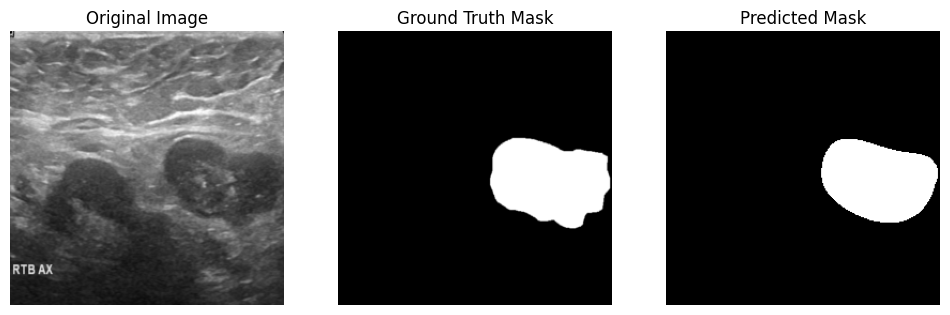

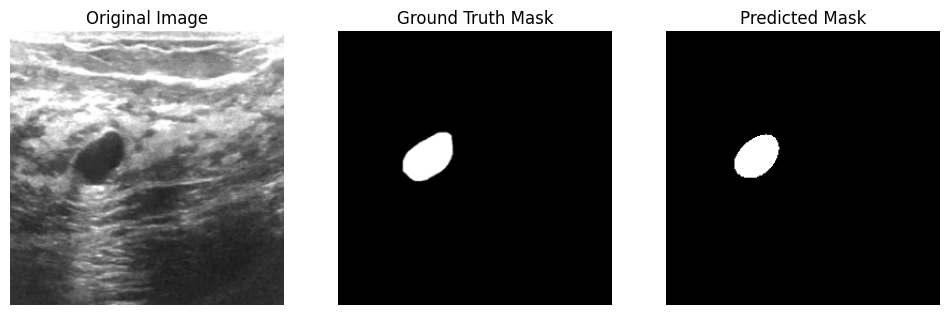

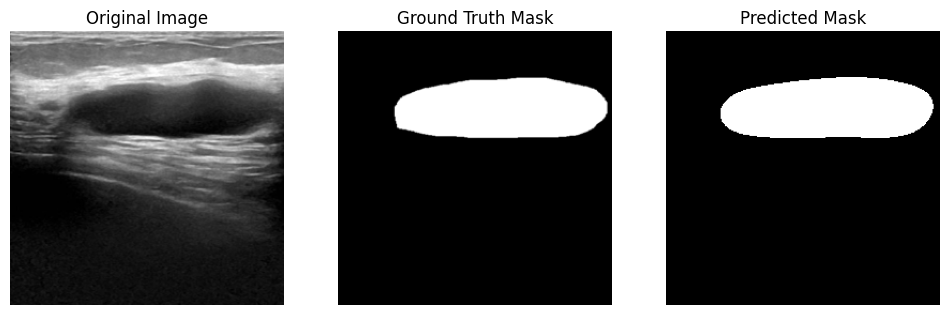

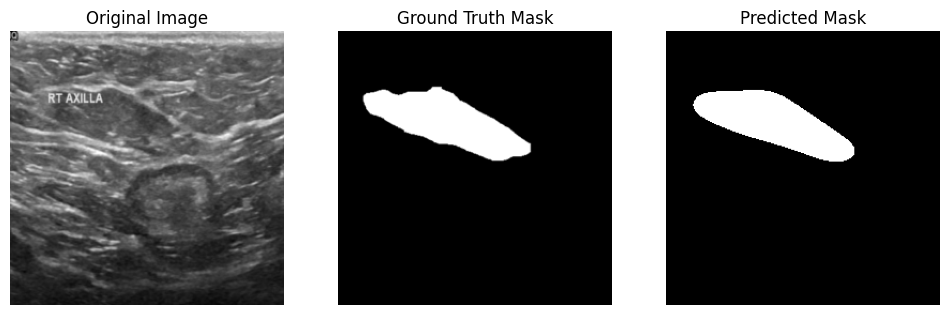

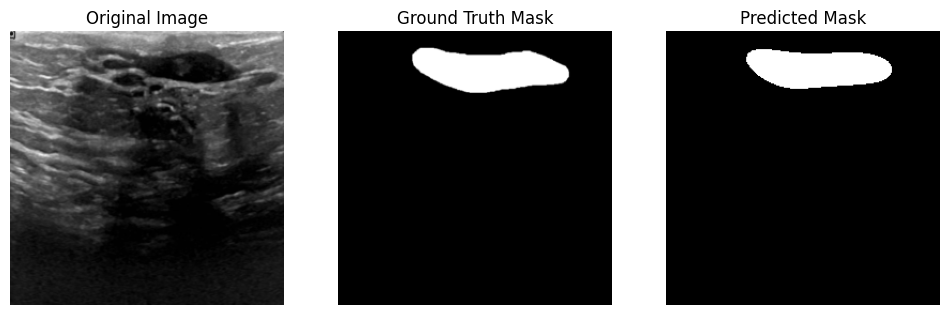

Test set examples:


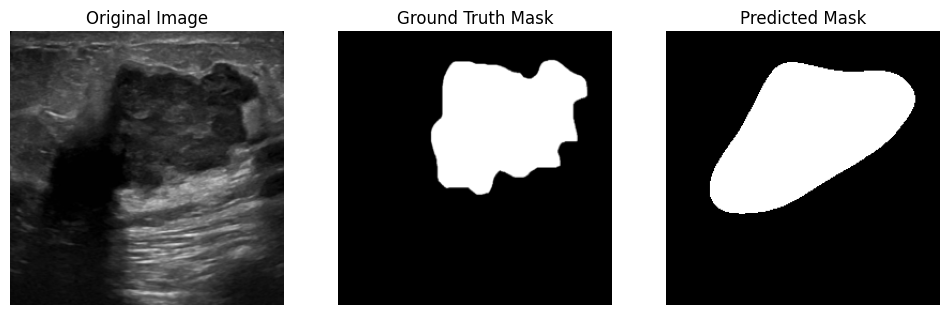

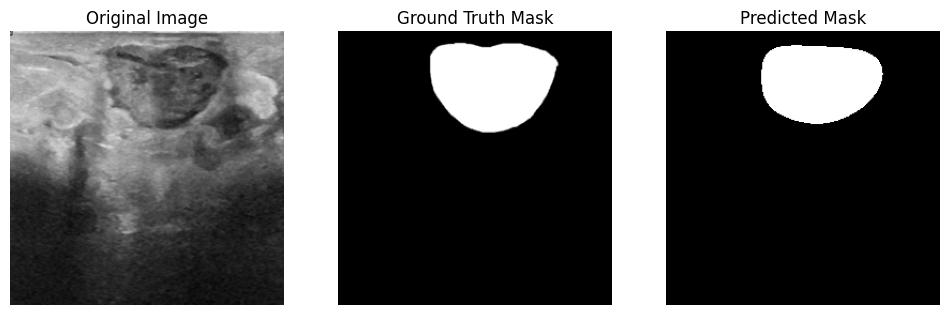

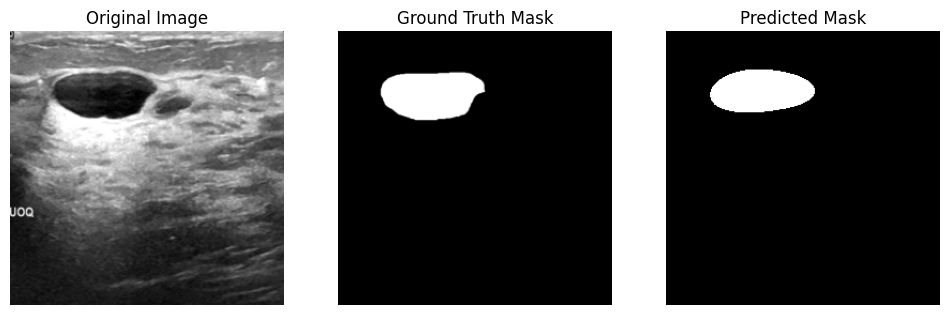

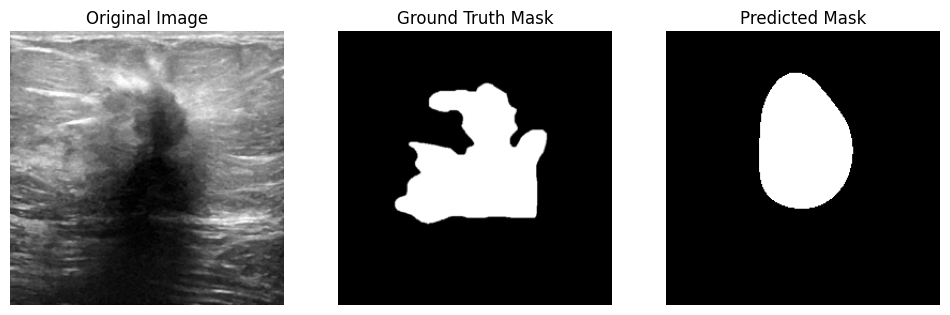

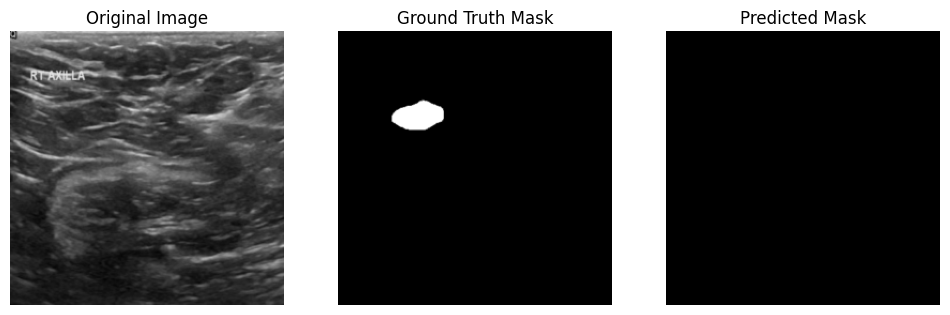

In [2]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=5):
    """
    Visualize predictions on a subset of the dataset.

    Args:
    - dataset: The dataset to visualize.
    - model: The trained segmentation model.
    - num_samples: Number of samples to visualize.
    """
    model.eval()  # Modeli değerlendirme moduna al

    for i in range(num_samples):
        # Dataset'ten bir görüntü ve maskeyi al
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).to(device)  # Batch boyutunu ekle ve cihazına taşı

        with torch.no_grad():
            # Model tahmini al
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid uygula ve CPU'ya taşı
            prediction_binary = (prediction > 0.5).astype(np.uint8)  # İkili hale getir

        # Görselleri çiz
        plt.figure(figsize=(12, 4))

        # Orijinal görüntü
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # CHW'den HWC'ye dönüştür
        plt.title("Original Image")
        plt.axis("off")

        # Gerçek maske
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Tahmin edilen maske
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Görselleştirme: Eğitim setindeki 5 örnek
print("Training set examples:")
visualize_predictions(train_dataset, model, num_samples=5)

# Görselleştirme: Test setindeki 5 örnek
print("Test set examples:")
visualize_predictions(test_dataset, model, num_samples=5)
